# Package Import

In [0]:
from IPython.display import clear_output
!pip install yfinance
!pip install mpl_finance
clear_output()

In [4]:
import pandas as pd
import numpy as np
from datetime import date
import yfinance as yf
from mpl_finance import candlestick2_ochl
import matplotlib.pyplot as plt

from keras.models import load_model, save_model

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Flatten, Activation, add
from keras.layers import Dropout, Flatten, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras import initializers
from keras.engine import Layer, InputSpec
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, rmsprop

Using TensorFlow backend.


# Core

in this part, we will us the best model obtained from "Stock Price Movement Prediction - Best Variation Review". Then, use the model to do a simulation. The simualtion consist of :<br>
1. **Predict The Movement**<br>
firstly, we predict the movement or the result of the convolutional neural network by using the best variation ( model 3, timestep 60, and timegap 14). 
2. **Trading Simulation**<br>
Secondly, we will simulate the trading of stock with the target to get the most profit. This step may variate and can be optimized later. Because of the Timestep we used is 14, it means we will predict the 14 later day movement relative to the latest day. we will use the deposit technique to resolve the timestep problem.

In [5]:
# Firslt, We determine the stock
stock = 'BBCA.JK'
# the year of simulation
year_simulation = 2020
# determine the timestep and timegap
timestep = 60
timegap = 14

# load the data
data = yf.download(stock,'2000-01-01','2020-12-31')
data = data.reset_index()
data['Year'] = [data.loc[i,'Date'].year for i in range(data.shape[0])]


[*********************100%***********************]  1 of 1 completed


In [0]:
# we will take a little data from the late previous year to simulate in the beginning of the chosen year.(+ 60 day)
year = [year_simulation-1,year_simulation]

train = data[[data.loc[j,'Year'] in year for j in range(data.shape[0])]]
train = train.reset_index().drop('index',axis = 1)
first_day_of_simulation_index = train[train['Year']==year_simulation].index[0]
pure_train = train[first_day_of_simulation_index-timestep:]
pure_train = pure_train.reset_index().drop('index', axis = 1)

In [0]:
# use dark background to make the background value into 0 after we change the candlestick image into pixel RGB representation
plt.style.use('dark_background')
train_temp_x = []
train_temp_y = []

# use the same code as the previous notebook to convert tabular data into RGB representation 
for k in range(0,train.shape[0]-timestep):
    c = pure_train.loc[k:k + int(timestep) -1, :]
    if len(c) == int(timestep):
        my_dpi = 96
        fig = plt.figure(figsize=(100 / my_dpi,
                                    100 / my_dpi), dpi=my_dpi)
        ax = fig.add_subplot(1, 1, 1)
        candlestick2_ochl(ax, c['Open'], c['Close'], c['High'],
                            c['Low'], width=0.85,
                            colorup='#77d879', colordown='#db3f3f', alpha = 1)
        ax.axis('off')
        fig.canvas.draw()
        temp_temp_x = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        plt.close();
        clear_output()
        temp_temp_x = (temp_temp_x.reshape(fig.canvas.get_width_height()[::-1] + (3,))/255).tolist()
        train_temp_x.append(temp_temp_x)

In [0]:
# the input is now ready
ex = np.array(train_temp_x)

# load the model which is saved
model_simulation = load_model('{}_model3_timestep60_timegap14.hdf5'.format(stock))
pred = model_simulation.predict(ex)
pred = pred.reshape(pred.shape[0])

In [0]:
# create a table with a new column that represent the prediction 
pure_train['pred'] = [np.nan]*(timestep-1)+pred.tolist()
simulation_data = pure_train.dropna().reset_index().drop('index', axis = True)
simulation_data['pred'] = np.round(simulation_data['pred'])

In [0]:
# determine the initial money
initial_money = 100000000
# create a list of asset movement 
asset = [initial_money]
# initiate the real money, number of stock, and dictionary
# the dictionary will be used to store the date we will pull our stock (sell)
real_money = initial_money
n_stock = 0
dicts = {}

# iterate daily
for i in range(simulation_data['pred'].shape[0]):
    try:
        real_money = real_money + dicts[i]*simulation_data.loc[i,'Close'] 
        n_stock = n_stock - dicts[i]
    except:
        pass

    if simulation_data.loc[i,'pred']==1:
        # we will buy constantly 10000000
        if real_money >=10000000:
            n_stock = n_stock + 10000000//simulation_data.loc[i,'Close']
            dicts[i+14] = 10000000//simulation_data.loc[i,'Close']
            real_money = real_money - (10000000//simulation_data.loc[i,'Close'])*simulation_data.loc[i,'Close']
        
        # if the money is less than 10000000 we will use the rest of the money then
        else:
            n_stock = n_stock + real_money//simulation_data.loc[i,'Close']
            dicts[i+14] = real_money//simulation_data.loc[i,'Close']
            real_money = real_money - (real_money//simulation_data.loc[i,'Close'])*simulation_data.loc[i,'Close']
            
    # appent the asset movement for every iteration
    asset.append(real_money + n_stock*simulation_data.loc[i,'Close'])

In [0]:
# Asset movement by investing, as comparison
asset_invest = [(initial_money//simulation_data.loc[0,'Close'])*simulation_data.loc[i,'Close'] + (initial_money%simulation_data.loc[0,'Close']) for i in range(simulation_data.shape[0])]

BBCA.JK


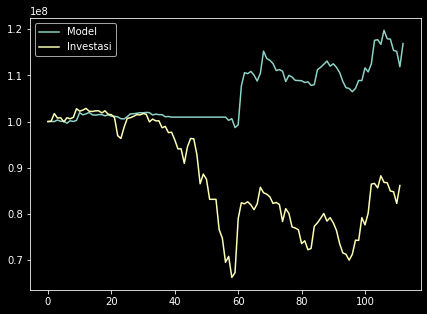

In [13]:
# create the table for the investment asset and asset from simulation using model
hasil = pd.DataFrame([asset,asset_invest]).T
hasil.columns = ['Model', 'Investasi']

print(stock)
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5
plt.style.use('dark_background')
hasil.plot(kind = 'line')